In [112]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt

simulator = Aer.get_backend('aer_simulator')

# Machine Learning Quantique

Plusieurs méthodes ont été imaginées pour utiliser des ordinateurs quantiques pour du machine learning. Nous allons appliqué une de ces méthodes pour extrapoler une fonction en utilisant un nombre réduit de qubits.

## Préparation des paramétres

In [113]:
# Paramétres du circuit
nqubits = 3
train_depth = 3
time_steps = 0.77

In [114]:
## Taille de l'ensemble d'entraînement
x_min = - 1.; x_max = 1.
num_x_train = 20

## Fonction que l'on veut extrapoler
func_to_learn = lambda x: np.sin(x*np.pi)

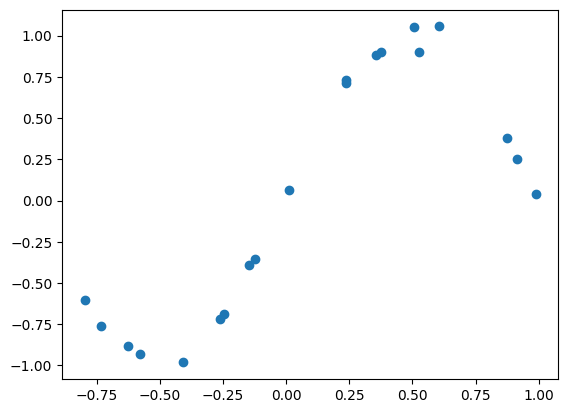

In [115]:
#### Préparation de l'ensemble d'entraînement

train_x = x_min + (x_max - x_min) * np.random.rand(num_x_train)
train_y = func_to_learn(train_x)

# Ajout de bruit pour rendre l'exemple plus réaliste
mag_noise = 0.05
train_y = train_y + mag_noise * np.random.randn(num_x_train)

y_min = min(train_y)
y_max = max(train_y)

amp_y = y_max - y_min

plt.plot(train_x, train_y, "o")
plt.show()

## Construction du circuit

Le circuit se décompose en plusieurs étapes. On commence par initialiser notre état selon la valeur d'entrée. L'encodage ci-dessous de $U_{in}$ fonctionne pour des ensembles compris dans $[-1,1]$ et consiste en $RZ(\arccos(x^2))RY(\arcsin(x))$ sur chaque qubit.

In [116]:
def U_in(x):
    qc = QuantumCircuit(nqubits)
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    for i in range(nqubits):
        qc.ry(angle_y, i)
        qc.rz(angle_z, i)
    return qc

Pour intriquer les qubits, nous utliserons un opérateur d'évolution $e^{iHt}$ avec $i$ l'unité imaginaire, $H$ un hamiltonien et $t$ un intervalle de temps que l'on pose arbitrairement. Le hamiltonien que l'on utilisera sera celui d'un modèle d'Ising, avec une implémentation récupérée depuis une source externe.

In [117]:
from functools import reduce

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Receive list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] ,
    insert Identity into irrelevent qubit, and create (2**nqubit, 2**nqubit) size matrix
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''    
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = []  ## list single 1-qubit gates and reduce them using np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## insert identity if i is not included in list_Site
            list_SingleGates.append(I)

    return reduce(np.kron, list_SingleGates)

ham = np.zeros((2**nqubits,2**nqubits), dtype = complex)
for i in range(nqubits): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number between -1~1
    ham += Jx * make_fullgate( [ [i, X] ], nqubits)
    for j in range(i+1, nqubits):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z], [j, Z]], nqubits)

## Create a time evolution operator by diagonalizing.  H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_steps*diag))), eigen_vecs.T.conj()) # e^-iHT

In [118]:
time_evol_op.shape

(8, 8)

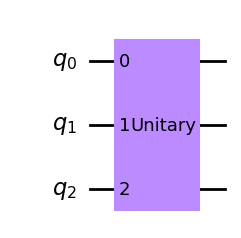

In [119]:
# convert time_evol_op to a qiskit operator
from qiskit.quantum_info import Operator
time_evol_op = Operator(time_evol_op)
evolve = QuantumCircuit(nqubits)
evolve.unitary(time_evol_op, range(nqubits))
evolve.draw('mpl')

Pour les faire évoluer, nous utiliserons des blocks comme suit qui permettent de transformer chaque qubit en n'importe quelle autre état en modifiant les paramétres d'angles.

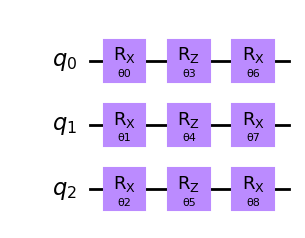

In [120]:
U_rot = QuantumCircuit(nqubits)
# Create 3*nqubits parameters for the rotation gates rx, rz, rx on each qubit for U_rot
params = [Parameter('θ'+str(i)) for i in range(3*nqubits)]
for i in range(nqubits):
    U_rot.rx(params[i], i)
    U_rot.rz(params[i+nqubits], i)
    U_rot.rx(params[i+2*nqubits], i)
U_rot.draw('mpl')

L'opération de machine learning se compose d'une répétition d'intrication et de blocks paramétrés un certains nombre de fois.

In [121]:
def U_out(parmameters):
    qc = QuantumCircuit(nqubits)
    for c in range(train_depth):
        qc.compose(evolve, inplace=True)
        rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})
        qc.compose(rot_gate, inplace=True)
    return qc

Voici donc le circuit complet une fois assemblé.

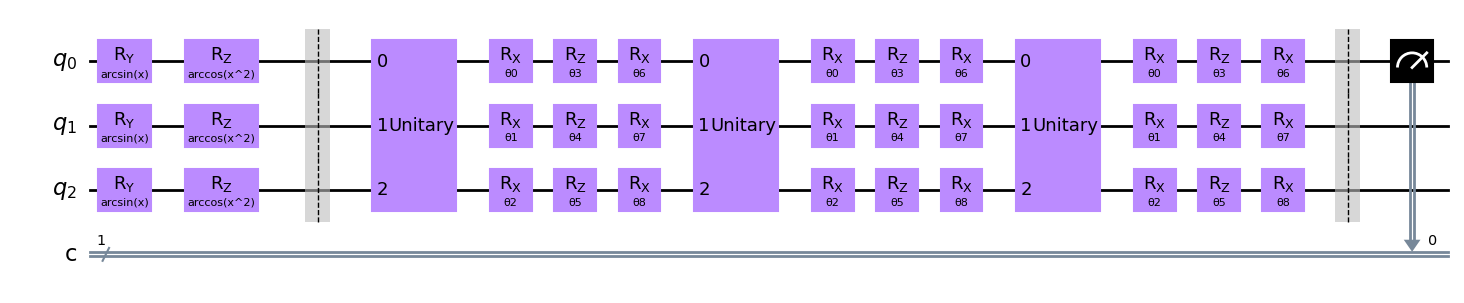

In [122]:
qc_draw = QuantumCircuit(nqubits,1)

angle_y = Parameter('arcsin(x)')
angle_z = Parameter('arccos(x^2)')
for i in range(nqubits):
        qc_draw.ry(angle_y, i)
        qc_draw.rz(angle_z, i)

qc_draw.barrier()

for c in range(train_depth):
        qc_draw.compose(evolve, inplace=True)
        qc_draw.compose(U_rot, inplace=True)

qc_draw.barrier()

qc_draw.measure(0,0)

qc_draw.draw('mpl')

Pour la mesure nous mesurons que le premier qubit. Nous comptons le rapport de 0 sur le total des mesures et on augmente ensuite l'amplitude pour pouvoir se coller à nos données. 

In [123]:
def circ_meas(qc):
    qc.measure_all()
    qc = transpile(qc, simulator)
    counts = simulator.run(qc).result().get_counts()
    tot_counts = sum(counts.values())
    zero_state = 0
    for key in counts:
        if key[0] == '0':
            zero_state += counts[key]
    expected = zero_state/tot_counts
    return expected*amp_y + y_min

In [124]:
def complete_circuit(x, *parameters):
    qc = QuantumCircuit(nqubits)
    qc.compose(U_in(x), inplace=True)
    qc.compose(U_out(*parameters), inplace=True)
    return circ_meas(qc)

## Entrainement du circuit

On prépare des paramétres initiaux.

In [125]:
# Create a set of initial parameters
initial_parameters = np.random.rand(train_depth, 3*nqubits)*2*np.pi
initial_parameters = initial_parameters.flatten()
initial_parameters.shape

(27,)

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


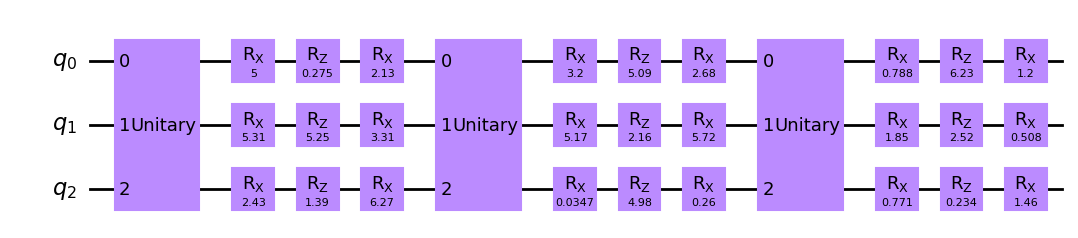

In [126]:
U_out(initial_parameters).draw('mpl')

Créons une fonction de coût qui mesure l'écart entre notre modèle et les données.

In [127]:
def cost_function(parameters):
    tot = []
    x = train_x
    y = train_y
    for i in range(len(x)):
        expected = complete_circuit(x[i], parameters)
        cost = (expected - y[i])**2
        tot.append(cost)
    return np.mean(tot)

Voici donc les différents outils avant l'entrainement.

In [128]:
cost_function(initial_parameters)

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


0.9056869572216314

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


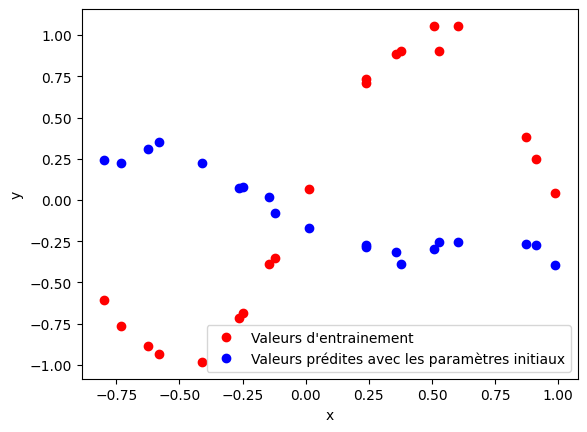

In [129]:
plt.plot(train_x, train_y, 'ro', label="Valeurs d'entrainement")
plt.plot(train_x, [complete_circuit(x, initial_parameters) for x in train_x], 'bo', label="Valeurs prédites avec les paramètres initiaux")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")

### Première méthode

La première méthode d'optimisation est assez naive. Nous testons en modifiant chaque paramétres un peu plus haut et un peu plus bas et on prend celui le plus optimal. On répéte cela autant que nécessaire.

In [130]:
def opt_simp(depth, step):
    int_cost = []
    opt_param = initial_parameters.copy()
    prev_cost = cost_function(opt_param)
    for _ in range(depth):
        for i in range(3*nqubits*train_depth):
            opt_param[i] += step
            c1 = cost_function(opt_param)
            opt_param[i] -= 2*step
            c2 = cost_function(opt_param)
            if prev_cost < c1 and prev_cost < c2:
                opt_param[i] += step
                int_cost.append(prev_cost)
            elif c1 < c2:
                opt_param[i] += 2*step
                int_cost.append(c1)
                prev_cost = c1
            else:
                int_cost.append(c2)
                prev_cost = c2
    
    return (int_cost, opt_param)

In [131]:
example_desc, example_opt = opt_simp(20, 0.1)

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


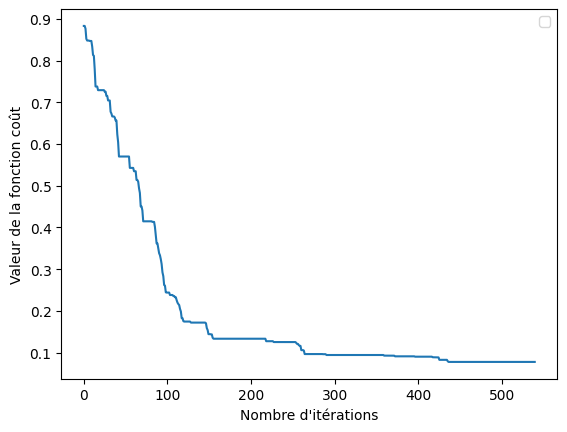

In [132]:
plt.plot(example_desc)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur de la fonction coût")
plt.legend()

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


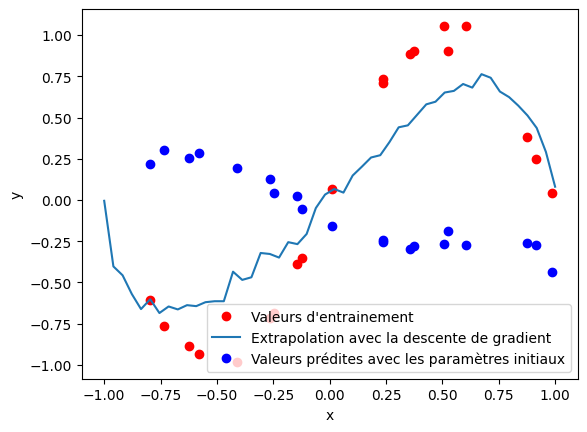

In [133]:
plt.plot(train_x, train_y, 'ro', label="Valeurs d'entrainement")
plt.plot(np.linspace(-1,1), [complete_circuit(x, example_opt) for x in np.linspace(-1,1)], '-', label="Extrapolation avec la descente de gradient")
plt.plot(train_x, [complete_circuit(x, initial_parameters) for x in train_x], 'bo', label="Valeurs prédites avec les paramètres initiaux")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


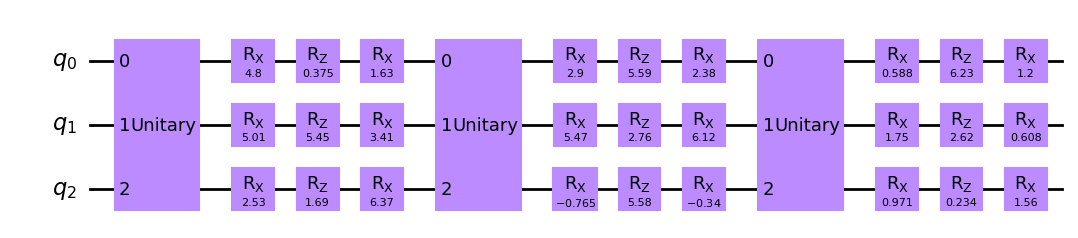

In [134]:
U_out(example_opt).draw('mpl')

### Deuxième méthode

Pour la deuxième nous utiliserons une méthode plus standard, une descente de gradient. Nous calculons donc le gradient (taux d'évolution) de notre fonction de coût selon les paramétres et nous les faisons évoluer en conséquence.

In [135]:
def opt_grad(depth, step, rate):
    int_cost = []
    opt_param = initial_parameters.copy()
    for _ in range(depth):
        grad = np.zeros(3*nqubits*train_depth)
        for i in range(3*nqubits*train_depth):
            c = cost_function(opt_param)
            opt_param[i] += step
            c1 = cost_function(opt_param)
            opt_param[i] -= step
            grad[i] = (c1 - c)/step
            
        opt_param -= rate*grad
        int_cost.append(cost_function(opt_param))

    return (int_cost, opt_param)

In [146]:
example_desc, example_opt = opt_grad(20, 0.1, 0.1)

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


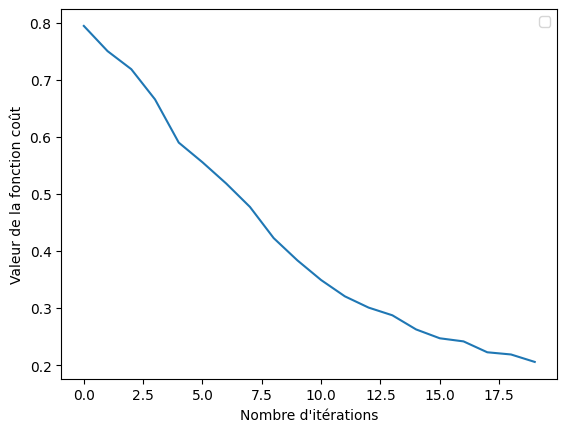

In [147]:
plt.plot(example_desc)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur de la fonction coût")
plt.legend()

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


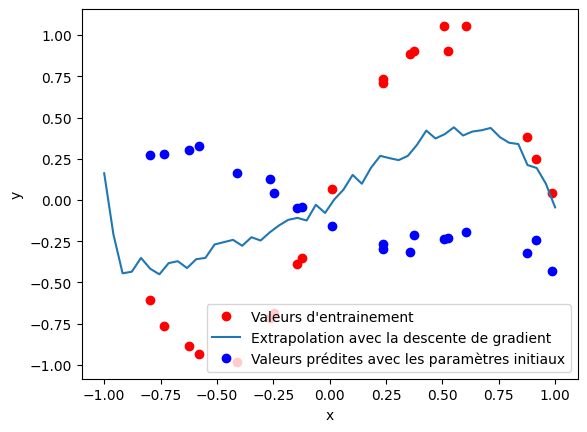

In [148]:
plt.plot(train_x, train_y, 'ro', label="Valeurs d'entrainement")
plt.plot(np.linspace(-1,1), [complete_circuit(x, example_opt) for x in np.linspace(-1,1)], '-', label="Extrapolation avec la descente de gradient")
plt.plot(train_x, [complete_circuit(x, initial_parameters) for x in train_x], 'bo', label="Valeurs prédites avec les paramètres initiaux")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

C:\Users\romai\AppData\Local\Temp\ipykernel_10816\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


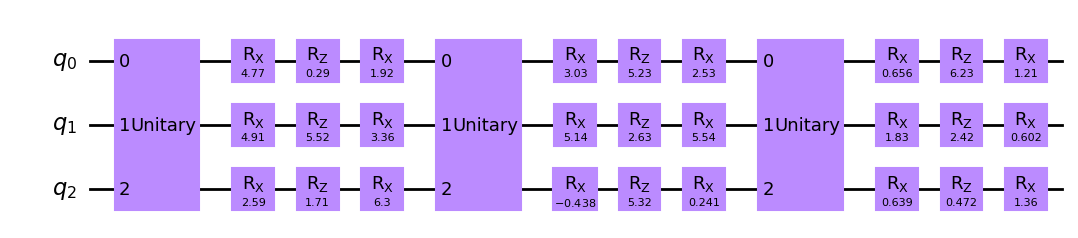

In [149]:
U_out(example_opt).draw('mpl')